In [ ]:
%matplotlib inline

In [1]:
from ultralytics.models.yolo.segment import SegmentationTrainer
args = dict(model="yolo11n-seg.pt", data="coco8-seg.yaml", epochs=3)
trainer = SegmentationTrainer(overrides=args)
trainer._setup_train(1)
train_dataset = trainer.build_dataset(trainer.trainset, mode="test", batch=16)

WARNING  Known issue with torch==2.4.0 on Windows with CPU, recommend upgrading to torch>=2.4.1 to resolve https://github.com/ultralytics/ultralytics/issues/15049
Ultralytics 8.3.69  Python-3.8.20 torch-2.4.0+cpu CPU (AMD Ryzen 7 7800X3D 8-Core Processor)
engine\trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=coco8-seg.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cla

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


YOLO11n-seg summary: 355 layers, 2,876,848 parameters, 2,876,832 gradients, 10.5 GFLOPs

Transferred 561/561 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'


train: Scanning C:\Users\syedd\Documents\mine\DCLC3\notebooks\datasets\coco8-seg\labels\train.cache.
val: Scanning C:\Users\syedd\Documents\mine\DCLC3\notebooks\datasets\coco8-seg\labels\val.cache... 4


Plotting labels to runs\segment\train12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)


test: Scanning C:\Users\syedd\Documents\mine\DCLC3\notebooks\datasets\coco8-seg\labels\train.cache..


In [23]:
data = train_dataset[0]

In [24]:
data

{'im_file': 'C:\\Users\\syedd\\Documents\\mine\\DCLC3\\notebooks\\datasets\\coco8-seg\\images\\train\\000000000009.jpg',
 'ori_shape': (480, 640),
 'resized_shape': (640, 640),
 'ratio_pad': ((1.0, 1.0), (0, 80)),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'img': tensor([[[114, 114, 114,  ..., 114, 114, 114],
          [114, 114, 114,  ..., 114, 114, 114],
          [114, 114, 114,  ..., 114, 114, 114],
          ...,
          [114, 114, 114,  ..., 114, 114, 114],
          [114, 114, 114,  ..., 114, 114, 114],
          [114, 114, 114,  ..., 114, 114, 114]],
 
         [[114, 114, 114,  ..., 114, 114, 114],
          [114, 114, 114,  ..., 114, 114, 114],
          [114, 114, 114,  ..., 114, 114, 114],
          ...,
          [114, 114, 114,  ..., 114, 114, 114],
    

In [25]:
data['img'].shape, data["masks"].shape

(torch.Size([3, 640, 640]), torch.Size([1, 160, 160]))

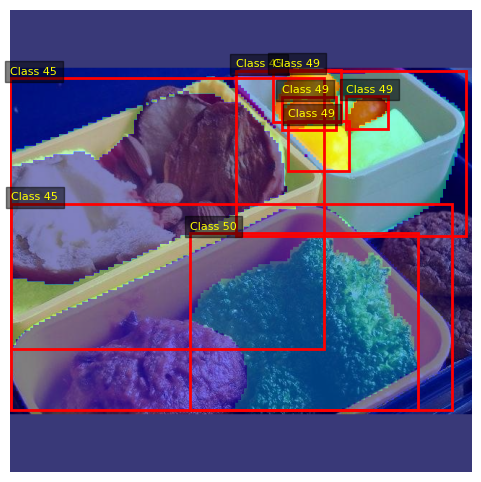

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

def visualize_data(data):
    # Close any previous plots to prevent memory leaks
    plt.close('all')

    # Convert image tensor to numpy array and transpose to (H, W, C)
    image = data['img'].numpy().transpose(1, 2, 0).astype(np.uint8)

    # Resize mask to match image dimensions
    mask = data['masks'].numpy()[0]
    mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create figure
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image)

    # Get bounding boxes and class labels
    bboxes = data['bboxes'].numpy() * np.array([image.shape[1], image.shape[0], image.shape[1], image.shape[0]])  # Scale
    cls = data['cls'].numpy().astype(int)

    # Ensure bounding box dimensions are valid
    for i, (x, y, w, h) in enumerate(bboxes):
        x, y, w, h = map(int, (x, y, w, h))  # Convert to integers
        x1, y1 = max(0, x - w // 2), max(0, y - h // 2)  # Ensure within bounds
        w, h = min(image.shape[1] - x1, w), min(image.shape[0] - y1, h)  # Clamp sizes

        rect = plt.Rectangle((x1, y1), w, h, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f'Class {cls[i][0]}', color='yellow', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))

    # Overlay segmentation mask
    ax.imshow(mask_resized, alpha=0.5, cmap='jet')

    # Hide axis and show plot
    ax.axis('off')
    plt.show(block=True)
    return mask_resized

mask = visualize_data(data)  # Should now work fine on repeated runs


In [57]:
??trainer.model.forward

Signature: trainer.model.forward(x, *args, **kwargs)
Source:   
    def forward(self, x, *args, **kwargs):
        """
        Perform forward pass of the model for either training or inference.

        If x is a dict, calculates and returns the loss for training. Otherwise, returns predictions for inference.

        Args:
            x (torch.Tensor | dict): Input tensor for inference, or dict with image tensor and labels for training.
            *args (Any): Variable length argument list.
            **kwargs (Any): Arbitrary keyword arguments.

        Returns:
            (torch.Tensor): Loss if x is a dict (training), or network predictions (inference).
        """
        if isinstance(x, dict):  # for cases of training and validating while training.
            return self.loss(x, *args, **kwargs)
        return self.predict(x, *args, **kwargs)
File:      c:\users\syedd\miniconda3\envs\openmmlab\lib\site-packages\ultralytics\nn\tasks.py
Type:      method

In [59]:
trainer.train()

WARNING  NeptuneAI installed but not initialized correctly, not logging this run. 

----NeptuneMissingApiTokenException-------------------------------------------

The Neptune client couldn't find your API token.

You can get it here:
    - https://app.neptune.ai/get_my_api_token

There are two options to add it:
    - specify it in your code
    - set an environment variable in your operating system.

CODE
Pass the token to the init_run() function via the api_token argument:
    neptune.init_run(project='WORKSPACE_NAME/PROJECT_NAME', api_token='YOUR_API_TOKEN')

ENVIRONMENT VARIABLE (Recommended option)
or export or set an environment variable depending on your operating system:

    Linux/Unix
    In your terminal run:
        export NEPTUNE_API_TOKEN="YOUR_API_TOKEN"

    Windows
    In your CMD run:
        set NEPTUNE_API_TOKEN="YOUR_API_TOKEN"

and skip the api_token argument of the init_run() function:
    neptune.init_run(project='WORKSPACE_NAME/PROJECT_NAME')

You may also wan

train: Scanning C:\Users\syedd\Documents\mine\DCLC3\notebooks\datasets\coco8-seg\labels\train.cache.
val: Scanning C:\Users\syedd\Documents\mine\DCLC3\notebooks\datasets\coco8-seg\labels\val.cache... 4

Plotting labels to runs\segment\train12\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\segment\train12
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G     0.7961      2.201      3.283      1.189         21        640: 100%|█████
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P 

                   all          4         17      0.779      0.894      0.939      0.662      0.721      0.836      0.821      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G     0.8832       3.13      2.879      1.167         23        640: 100%|█████
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P 

                   all          4         17      0.779      0.901      0.939      0.668       0.72      0.841      0.821      0.563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      1.193      2.465      2.846      1.467         25        640: 100%|█████
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P 

                   all          4         17      0.776      0.902      0.938       0.67      0.716      0.842      0.821      0.566



3 epochs completed in 0.002 hours.
Optimizer stripped from runs\segment\train12\weights\last.pt, 6.1MB
Optimizer stripped from runs\segment\train12\weights\best.pt, 6.1MB

Validating runs\segment\train12\weights\best.pt...
Ultralytics 8.3.69  Python-3.8.20 torch-2.4.0+cpu CPU (AMD Ryzen 7 7800X3D 8-Core Processor)
YOLO11n-seg summary (fused): 265 layers, 2,868,664 parameters, 0 gradients, 10.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P 


                   all          4         17      0.776      0.903      0.938      0.669      0.715      0.842      0.821      0.566
                person          3         10      0.734      0.554      0.653      0.317      0.734      0.554      0.609      0.259
                   dog          1          1      0.728          1      0.995      0.895      0.728          1      0.995      0.895
                 horse          1          2      0.608          1      0.995      0.581      0.608          1      0.828        0.2
              elephant          1          2          1      0.865      0.995      0.332      0.635        0.5      0.501       0.25
              umbrella          1          1      0.662          1      0.995      0.995      0.662          1      0.995      0.895
          potted plant          1          1      0.924          1      0.995      0.895      0.924          1      0.995      0.895
Speed: 0.6ms preprocess, 37.5ms inference, 0.0ms loss, 1.1ms postproc

In [55]:
np.unique(mask)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8)

In [38]:
binary_mask = (mask>0).astype(int)

In [39]:
binary_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [49]:
np.unique(binary_mask), binary_mask.shape

(array([0, 1]), (640, 640))

In [52]:
classes = 8

In [53]:
pixel_to_class_mapping = {i + 1: i for i in range(classes)}
img_height, img_width = binary_mask.shape  # Get image dimensions
unique_values = np.unique(binary_mask)  # Get unique pixel values representing different classes
yolo_format_data = []

for value in unique_values:
    if value == 0:
        continue  # Skip background
    class_index = pixel_to_class_mapping.get(value, -1)
    if class_index == -1:
        LOGGER.warning(f"Unknown class for pixel value {value} in file , skipping.")
        continue

    # Create a binary mask for the current class and find contours
    contours, _ = cv2.findContours(
        (binary_mask == value).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )  # Find contours

    for contour in contours:
        if len(contour) >= 3:  # YOLO requires at least 3 points for a valid segmentation
            contour = contour.squeeze()  # Remove single-dimensional entries
            yolo_format = [class_index]
            for point in contour:
                # Normalize the coordinates
                yolo_format.append(round(point[0] / img_width, 6))  # Rounding to 6 decimal places
                yolo_format.append(round(point[1] / img_height, 6))
            yolo_format_data.append(yolo_format)

In [54]:
len(contours)

6

In [ ]:
import sys

INSTALL = False # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    REPO_PATH = "<FIXME>" # Specify a local path to the repository (or use installed package instead)
    sys.path.append(REPO_PATH)

In [ ]:
cd ../dinov2/

In [ ]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from mmseg.apis import init_model

import dinov2.eval.segmentation.models


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_segmenter(cfg, backbone_model):
    model = init_segmentor(cfg)
    model.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
    )
    if hasattr(backbone_model, "patch_size"):
        model.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))
    model.init_weights()
    return model

In [ ]:
cd C:/Users/syedd/Documents/mine/DCLC3

In [ ]:
from src.data.building_datasets import *
from torchvision.transforms import functional as F
from torchvision import transforms
from torchvision.transforms import transforms
from glob import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
import hydra
import lightning as pl
import omegaconf
from lightning import Callback, LightningDataModule, LightningModule, Trainer

In [ ]:
cfg = omegaconf.OmegaConf.load("configs/data/building_data.yaml")
datamodule: LightningDataModule = hydra.utils.instantiate(cfg)
datamodule.setup()

In [ ]:
len(datamodule.data_train)

In [ ]:
for data in datamodule.train_dataloader():
    break

In [ ]:
a=data[0][0]
plt.imshow(a.permute(1,2,0).cpu().numpy().astype(float))

In [ ]:
# Change the data to fit the huggingface input
data_dict = {
    "pixel_values": data[0],
    "pixel_mask": data[1].squeeze(1),
}
data_dict["pixel_values"].shape, data_dict["pixel_mask"].shape

In [ ]:
np.unique(data_dict["pixel_mask"])

In [ ]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


# load Mask2Former fine-tuned on Cityscapes semantic segmentation
# we only need one class
id2label =  {1: "building"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-cityscapes-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-small-cityscapes-semantic",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_queries=1
)

In [ ]:
model

### Update the forward function with the following code

In [ ]:
with torch.no_grad():
    outputs = model(**data_dict)

In [ ]:
class_queries_logits = outputs.class_queries_logits  # [batch_size, num_queries, num_classes+1]
masks_queries_logits = outputs.masks_queries_logits  # [batch_size, num_queries, height, width]

# Scale back to preprocessed image size - (384, 384) for all models
masks_queries_logits = torch.nn.functional.interpolate(
    masks_queries_logits, size=(384, 384), mode="bilinear", align_corners=False
)

# Remove the null class `[..., :-1]`
masks_classes = class_queries_logits.softmax(dim=-1)[..., :-1]
masks_probs = masks_queries_logits.sigmoid()  # [batch_size, num_queries, height, width]

# Semantic segmentation logits of shape (batch_size, num_classes, height, width)
segmentation = torch.einsum("bqc, bqhw -> bchw", masks_classes, masks_probs)
batch_size = class_queries_logits.shape[0]

# resize the logits to be of the input shape of 256 x 256
resized_logits = torch.nn.functional.interpolate(
                    segmentation, size=(256,256), mode="bilinear", align_corners=False
                )

# could be used as the final mask and apply threshold for final mask
sigmoid_logits = torch.sigmoid(resized_logits).squeeze(1)
binary_m = torch.where(sigmoid_logits > 0.01, torch.tensor(255, dtype=torch.uint8), torch.tensor(0, dtype=torch.uint8))


In [ ]:
pred_logits_transposed = class_queries_logits.transpose(1, 2)

In [ ]:
pred_logits_transposed.shape

### Checking trainable parameters

In [ ]:
# Assume model is the instance of Mask2FormerForUniversalSegmentation
trainable_params = []
non_trainable_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_params.append(name)
    else:
        non_trainable_params.append(name)

print("Trainable Parameters:")
for param_name in trainable_params:
    print(param_name)

print(f"\nTotal trainable parameters: {len(trainable_params)}")

print("\nNon-Trainable Parameters:")
for param_name in non_trainable_params:
    print(param_name)

print(f"\nTotal non-trainable parameters: {len(non_trainable_params)}")


In [ ]:
data_train = datamodule.data_train
data_val = datamodule.data_val

In [ ]:
np.array(data_train[0][1]).shape

In [ ]:
model.eval()
output = model(data_train[0][0].unsqueeze(0))

In [ ]:
with torch.no_grad():
    output_np = output[1].numpy()

In [ ]:
output_np.resize(256,256)